In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema

In [3]:
df = pd.read_csv("./data.csv")

In [4]:
df

,Дата,Заражений за день,Выздоровлений за день,Смертей за день
0,2020-03-12 00:00:00,34,0,0
1,2020-03-13 00:00:00,11,0,0
2,2020-03-14 00:00:00,14,0,0
3,2020-03-15 00:00:00,4,3,0
4,2020-03-16 00:00:00,28,2,0
...,...,...,...,...
1033,2023-01-09 00:00:00,2754,2990,41
1034,2023-01-10 00:00:00,3032,5062,47
1035,2023-01-11 00:00:00,4201,5122,46
1036,2023-01-12 00:00:00,4675,4541,48


In [5]:
df.rename(columns = {'Дата':'data','Заражений за день':'infected', 'Выздоровлений за день':'cured', 'Смертей за день':'deaths'}, inplace = True)

In [6]:
df.columns

Index(['data', 'infected', 'cured', 'deaths'], dtype='object')

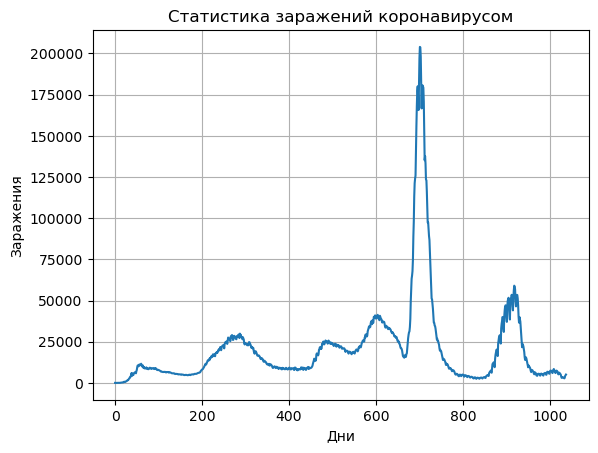

In [7]:
plt.plot(df['infected'])
plt.title('Статистика заражений коронавирусом')
plt.xlabel("Дни")
plt.ylabel("Заражения")
plt.grid()
plt.show()

In [8]:
deaths = df['infected'].copy
deaths

<bound method NDFrame.copy of 0         34
1         11
2         14
3          4
4         28
        ... 
1033    2754
1034    3032
1035    4201
1036    4675
1037    5078
Name: infected, Length: 1038, dtype: int64>

In [9]:
coefs = np.fft.fft(df['infected'])

In [10]:
coefs

array([21846722.        -1.49157131e-10j,
       -5577323.84223518+6.57441410e+06j,
       -3545565.60008133-4.38130918e+06j, ...,
        4484705.84751773-3.39072802e+06j,
       -3545565.60008133+4.38130918e+06j,
       -5577323.84223518-6.57441410e+06j])

In [11]:
cos = np.real(coefs)

In [12]:
cos

array([21846722.        , -5577323.84223518, -3545565.60008133, ...,
        4484705.84751773, -3545565.60008133, -5577323.84223518])

In [13]:
sin = np.imag(coefs)

In [14]:
sin

array([-1.49157131e-10,  6.57441410e+06, -4.38130918e+06, ...,
       -3.39072802e+06,  4.38130918e+06, -6.57441410e+06])

In [15]:
d_f = 1/df.shape[0]

In [27]:
def fourier_freq(days, freq, sin, cos):
    res = np.ones(days) * cos[0]/days
    for i in range(1,freq):
        for j in range(1, days):
            cosin = cos[i] * 2*np.cos(2*np.pi*i*d_f*j)/days
            sinus = -sin[i] * 2*np.sin(2*np.pi*i*d_f*j)/days
            res[j] += cosin + sinus
    return res

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

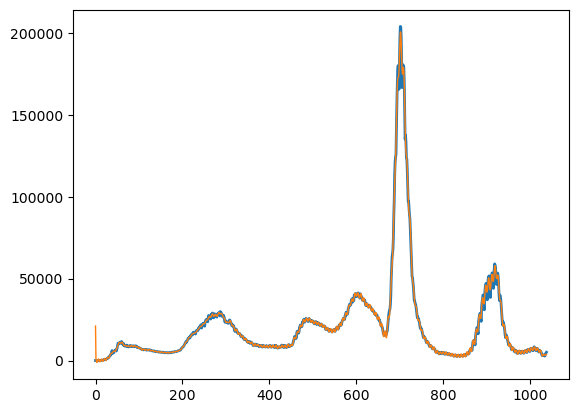

In [29]:
res_1 = fourier_freq(df.shape[0], 150, sin, cos)
plt.plot(df['infected'], linewidth= 2)
plt.plot(res_1, linewidth= 1)
# plt.axline((170, 0), (170, 0.9), color = 'red')
# plt.axline((340, 0), (340, 0.9), color = 'red')
# plt.axline((510, 0), (510, 0.9), color = 'red')
# plt.axline((680, 0), (680, 0.9), color = 'red')
# plt.axline((850, 0), (850, 0.9), color = 'red')
plt.plot

Таким образом, график, полученный с помощью преобразования Фурье, наиболее соответствует исходному при рассмотрении первых 150 частот. Это означает, что период низкочастотных колебаний равен 1038/150 = 7 дням, что может быть связано с периодом болезни/инкубационным периодом коронавируса.

Для нахождения пиков волн заболеваемости, оценим низкочастотный период прироста. Из графика следует, что прошло шесть волн заболевания коронавирусом. Тогда период одной волны примерно равен 1038/6 = 173 дням. Разделим данные на периоды по 173 дня:

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

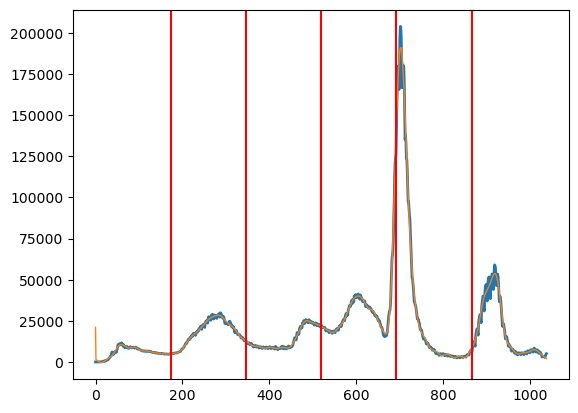

In [73]:
res_2 = fourier_freq(df.shape[0], 40, sin, cos)
plt.plot(df['infected'], linewidth= 2)
plt.plot(res_2, linewidth= 1)
plt.axline((173, 0), (173, 0.9), color = 'red')
plt.axline((346, 0), (346, 0.9), color = 'red')
plt.axline((519, 0), (519, 0.9), color = 'red')
plt.axline((692, 0), (692, 0.9), color = 'red')
plt.axline((865, 0), (865, 0.9), color = 'red')
plt.plot

Из графика видно, что пик каждой волны корректно попадает во все периоды. Найдём индексы локальных максимумов в каждом периоде и выберем тот, который соответствует пику:

In [74]:
borders = np.arange(0, df.shape[0] + 1, 173)

In [75]:
max_indexes = []
for i in range(0, borders.shape[0] - 1):
    indexes = argrelextrema(res_2[borders[i]:borders[i+1]], np.greater)[0]
    indexes += borders[i]
    max_ind = 0
    max_value = 0
    for elem in indexes:
        if res_2[elem] > max_value:
            max_ind = elem
            max_value = res_2[elem]
    max_indexes.append(max_ind)
print(max_indexes)

[59, 282, 486, 604, 702, 918]


Таким образом, даты с наивысшими заражениями в каждой волне:

In [76]:
for elem in max_indexes:
    print(df['data'][elem])

2020-05-10 00:00:00
2020-12-19 00:00:00
2021-07-11 00:00:00
2021-11-06 00:00:00
2022-02-12 00:00:00
2022-09-16 00:00:00
